# Locally Linear Stream Reference Frames on Perfect Data

In [1]:
"""
    TITLE   : Locally Linear Stream Reference Frame
    PROJECT : Stream Tracks
"""

__author__ = "Nathaniel Starkman"

<span style='font-size:30px;font-weight:650'>
    About
</span>

A common technique is 


<br><br>

- - - 


## Prepare

### Imports

In [2]:
# THIRD PARTY
import astropy.coordinates as coord
import astropy.units as u
import corner
import lmfit as lf
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from astropy.coordinates import SkyCoord
from astropy.visualization import imshow_norm
from utilipy import ipython

from src import get_transform_matrix

# LOCAL
# import trackstream as ts
from trackstream.example_data import example_coords
from trackstream.preprocess.rotated_frame import residual
from trackstream.utils.coordinates import reference_to_skyoffset_matrix

set autoreload to 1


In [3]:
ipython.set_autoreload(2)

set autoreload to 2


<br><br>

- - - 


## Data

Mock Data

In [4]:
rsc = example_coords.RotatedICRS(
    phi1=np.linspace(0, 2 * np.pi, 128) * u.radian,
    phi2=np.zeros(128) * u.radian,
)

icrs = rsc.transform_to(coord.ICRS)

/Users/nathanielstarkman/local/astropy/astropy/coordinates/baseframe.py:1192: AstropyDeprecationWarning: Transforming a frame instance to a frame class (as opposed to another frame instance) will not be supported in the future.  Either explicitly instantiate the target frame, or first convert the source frame instance to a `astropy.coordinates.SkyCoord` and use its `transform_to()` method.
  warnings.warn("Transforming a frame instance to a frame class (as opposed to another "



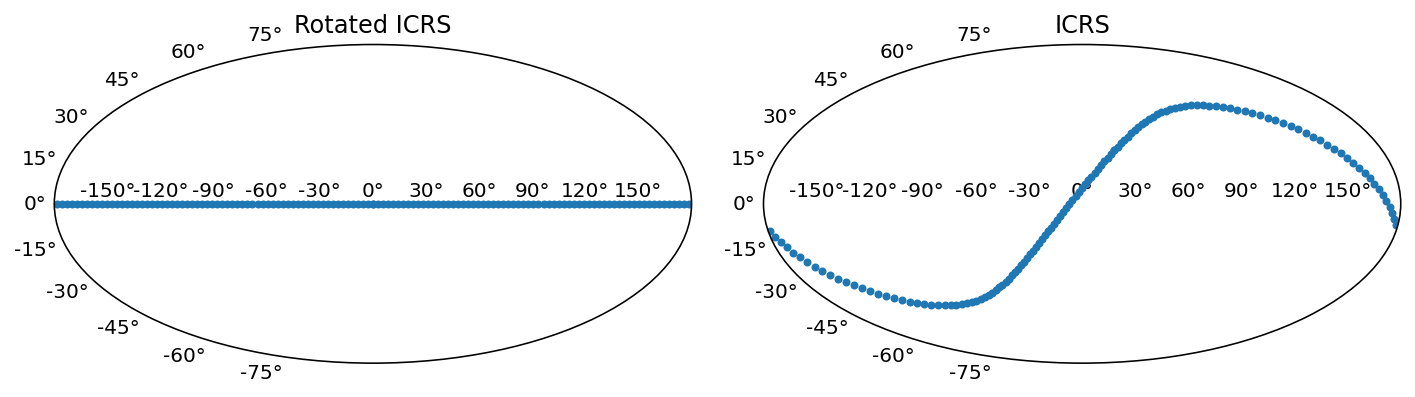

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "aitoff"})

axes[0].set_title("Rotated ICRS")
axes[0].plot(
    rsc.phi1.wrap_at(180 * u.deg).radian,
    rsc.phi2.radian,
    linestyle="none",
    marker=".",
)

axes[1].set_title("ICRS")
axes[1].plot(
    icrs.ra.wrap_at(180 * u.deg).radian,
    icrs.dec.radian,
    linestyle="none",
    marker=".",
)

plt.tight_layout()
plt.show();

<br><br>

- - - 


## Testing Transformation Matrices

Deriving matrix from RotatedICRS (Cartesian) to ICRS (Cartesian)

TODO have as pytest

In [6]:
# Direct derivation

test_rot = reference_to_skyoffset_matrix(
    example_coords.RA, example_coords.DEC, example_coords.ICRS_ROTATION
)

print(
    "Matrix matches original?",
    np.allclose(test_rot, example_coords.ICRS_ROT_MATRIX),
)

# From the SkyOffset frame

test_rot = get_transform_matrix(
    SkyCoord(ra=example_coords.RA, dec=example_coords.DEC).skyoffset_frame(
        rotation=example_coords.ICRS_ROTATION
    ),
    coord.ICRS,
)
test_rot

print("Matrix matches?", np.allclose(test_rot, example_coords.ICRS_ROT_MATRIX.T))

Matrix matches original? True


array([[ 0.81379768,  0.57292918,  0.09739349],
       [ 0.29619813, -0.55309513,  0.77868636],
       [ 0.5       , -0.60484538, -0.61980809]])

Matrix matches? True


Getting transformation matrix from RotatedICRS (Cartesian) to ICRS (Cartesian)

In [7]:
rot_matrix = get_transform_matrix(coord.ICRS, rsc)

print("Matrix matches?", np.allclose(rot_matrix, example_coords.ICRS_ROT_MATRIX))

rot_matrix

Matrix matches? True


array([[ 0.81379768,  0.29619813,  0.5       ],
       [ 0.57292918, -0.55309513, -0.60484538],
       [ 0.09739349,  0.77868636, -0.61980809]])

Testing transformation

In [8]:
icrs_xyz = np.dot(rot_matrix, rsc.cartesian.xyz)

print("Reversing transformatino worked?", np.allclose(icrs_xyz, icrs_xyz))

# and just confirming

new_icrs = coord.ICRS(
    x=icrs_xyz[0],
    y=icrs_xyz[1],
    z=icrs_xyz[2],
    representation_type="cartesian",
)

print("Extra check worked?", np.allclose(new_icrs.cartesian.xyz, icrs_xyz))

Reversing transformatino worked? True
Extra check worked? True


<br><br>

- - - 


## Residual Function

Showing over a grid.

Text(0.5, 0, '$\\theta$')

Text(0, 0.5, 'residual')

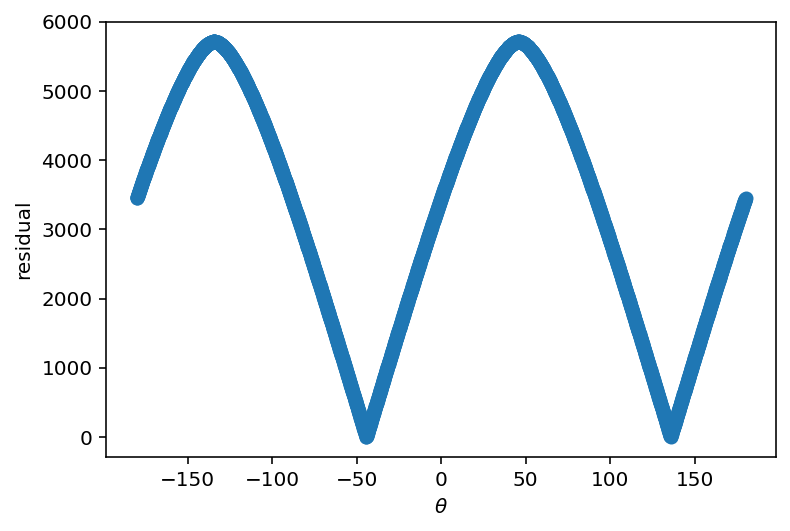

In [9]:
rs = np.linspace(-180, 180, num=3600)
res = np.array(
    [
        residual(
            (r, example_coords.RA.value, example_coords.DEC.value),
            data=icrs.cartesian,
            scalar=True,
        )
        for r in rs
    ]
)

plt.scatter(rs, res)
plt.xlabel(r"$\theta$")
plt.ylabel(r"residual")

In [10]:
rs = np.linspace(-180, 180, num=3600)
res2 = np.array(
    [
        residual(
            (r, example_coords.RA.value, example_coords.DEC.value),
            data=icrs.cartesian,
            scalar=False,
        )
        for r in rs
    ]
)

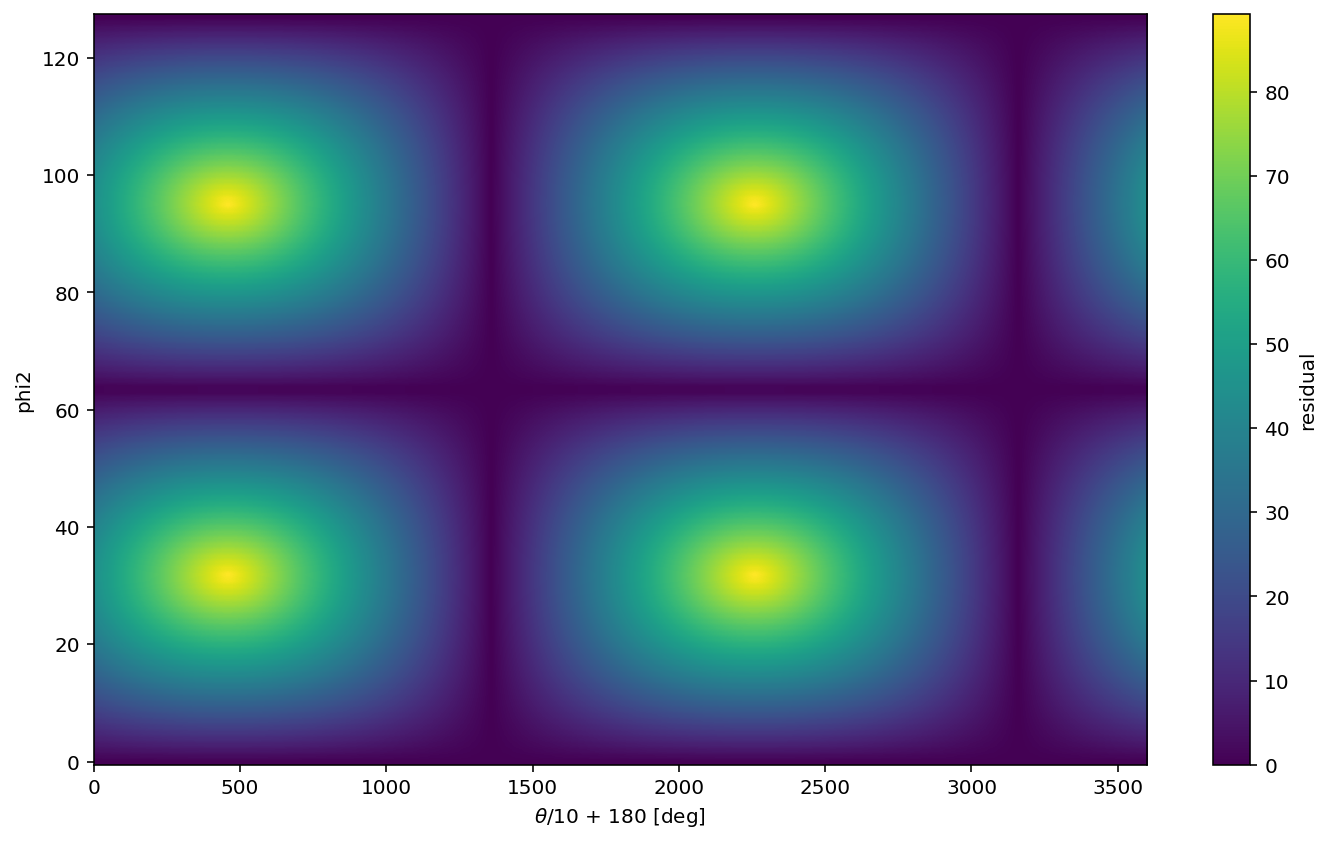

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

im, norm = imshow_norm(res2.T, ax=ax, aspect="auto", origin="lower")
plt.xlabel(r"$\theta$/10 + 180 [deg]")
plt.ylabel(r"phi2")

cbar = fig.colorbar(im)
cbar.ax.set_ylabel("residual")
plt.tight_layout();

**TODO** a plot of all the orbits colored by their probability

<br><br>

- - - 


## Scipy Minimization

In [12]:
bounds = np.array(
    [
        (-180, 180),
        (example_coords.RA.value - 0.001, example_coords.RA.value + 0.001),
        (example_coords.DEC.value - 0.001, example_coords.DEC.value + 0.001),
    ]
)
bounds

array([[-180.   ,  180.   ],
       [  19.999,   20.001],
       [  29.999,   30.001]])

In [13]:
res_scipy = opt.least_squares(
    residual,
    x0=[61, example_coords.RA.value, example_coords.DEC.value],
    args=(icrs.cartesian, False),
    method="trf",
    bounds=bounds.T,
)

# res_scipy
res_scipy.x

array([135.69968581,  19.99937229,  29.99946951])

In [14]:
res_scipy2 = opt.minimize(
    residual,
    x0=[61, example_coords.RA.value, example_coords.DEC.value],
    args=(icrs.cartesian, True),
    method="slsqp",
    bounds=bounds,
)

res_scipy2

     fun: 2.0019406551524487e-05
     jac: array([ 20.53812868,  40.01859147, -57.04499204])
 message: 'Optimization terminated successfully.'
    nfev: 133
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([135.69977398,  19.99954784,  29.99961754])

<br><br>

- - - 


## `lmfit` Minimization

In [15]:
params = lf.Parameters()
params.add_many(
    ("rotation", -40, True, -180, 180),
    ("lon", example_coords.RA.value, True, 18, 22),
    ("lat", example_coords.DEC.value, True, 28, 32),
)
params

name,value,initial value,min,max,vary
rotation,-40.0000000,-40,-180.000000,180.000000,True
lon,20.0000000,20.0,18.0000000,22.0000000,True
lat,30.0000000,30.0,28.0000000,32.0000000,True


In [16]:
mi = lf.minimize(
    residual.lmfit,
    params,
    kws=dict(data=icrs.cartesian, scalar=False),
    method="powell",
    calc_covar=True,
)
mi

In [17]:
# _params = params.copy()
# _params["rotation"].value = mi.params["rotation"].value + 10

# mi2 = lf.minimize(
#     residual.lmfit,
#     params,
#     kws=dict(data=icrs.cartesian, scalar=False),
#     method="least_squares",
#     calc_covar=False
# )
# mi2

Doing `emceee`

In [18]:
do_emcee = False

if do_emcee:
    mi.params.add("__lnsigma", value=np.log(0.1), min=np.log(0.001), max=np.log(2))

    mc = lf.minimize(
        residual.lmfit,
        kws=dict(data=icrs.cartesian.xyz.value, scalar=False),
        method="emcee",
        nan_policy="omit",
        burn=300,
        steps=int(1e5),
        thin=20,
        params=mi.params,
        is_weighted=False,
        progress=False,
    )

    print("median of posterior probability distribution")
    print("--------------------------------------------")
    lf.report_fit(mc.params)

    emcee_plot = corner.corner(
        mc.flatchain,
        labels=mc.var_names,
        truths=list(mc.params.valuesdict().values()),
    )

<br><br>

- - - 


## Breaking Degeneracy

There is a 180 degree degeneracy in any solution. We solve this by using the kinematics, such that the positive $\phi_1$ corresponds to the direction of motion.

<br><br>

- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>